## Importing libraries

In [1]:
import numpy as np
import pandas as pd 
import math


import os
from os import listdir
from os.path import isfile, join

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import imageio
from scipy import misc
import numpy as np
from scipy import misc
from random import shuffle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


## Reading dataset

In [2]:
fldr="C:/Users/shch/Desktop/Face_data_based_deeplearning-master/data/crop_part1"

files=os.listdir(fldr)

## Separating images and the age and gender labels into lists respectively

In [3]:
ages=[]
genders=[]
images=[]

for fle in files:
  age=int(fle.split('_')[0])
  gender=int(fle.split('_')[1])
  ages.append(age)
  genders.append(gender)
  total=fldr+'/'+fle

  #print(total)
  image=cv2.imread(total)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(128,128))
  images.append(image)

## Data preprocessing

In [4]:
#Preparing the feature set and removing non-male&female faces

X_data =[]

for file in files:
    if int(file.split('_')[1])!= 3:
        face = imageio.imread(fldr+'/'+file)
        face = cv2.resize(face, (32,32))
        X_data.append(face)
        

In [5]:
# Remove single dimensional entries from the shape of an array

X = np.squeeze(X_data)
#X
X.shape

(9779, 32, 32, 3)

In [6]:
# Normalize data

X = X.astype('float32')
X /= 255

In [7]:
# Target labels

classes = [a for a in genders if a != 3]
np.unique(classes)

array([0, 1])

In [8]:
# Preparing the target set

categorical_labels = to_categorical(classes,num_classes=2)

## Preparing the train,validation and test dataset

In [9]:
(x_train, y_train), (x_test, y_test) = (X[:8000],categorical_labels[:8000]) , (X[8000:] , categorical_labels[8000:])
(x_valid , y_valid) = (x_test[:890], y_test[:890])
(x_test, y_test) = (x_test[890:], y_test[890:])

In [10]:
len(x_train)+len(x_test) + len(x_valid) == len(X)

True

## Preparing the CNN model

In [11]:
model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))


model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='sigmoid'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2

In [12]:
# Defining the early stop to monitor the validation loss to avoid overfitting.

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')



model.compile(loss='binary_crossentropy',
             optimizer= 'adam',
             metrics=['accuracy'])


History = model.fit(x_train,
          y_train,
          batch_size=64,
          epochs=40,
 #         callbacks=[callback],
          validation_data=(x_valid, y_valid))


Train on 8000 samples, validate on 890 samples
Epoch 1/40
8000/8000 [==============================] - 50s 6ms/sample - loss: 0.6662 - accuracy: 0.5925 - val_loss: 0.6837 - val_accuracy: 0.5820
Epoch 2/40
8000/8000 [==============================] - 43s 5ms/sample - loss: 0.6227 - accuracy: 0.6499 - val_loss: 0.6486 - val_accuracy: 0.6348
Epoch 3/40
8000/8000 [==============================] - 42s 5ms/sample - loss: 0.6002 - accuracy: 0.6699 - val_loss: 0.6207 - val_accuracy: 0.6697
Epoch 4/40
8000/8000 [==============================] - 43s 5ms/sample - loss: 0.5793 - accuracy: 0.6891 - val_loss: 0.5818 - val_accuracy: 0.6888
Epoch 5/40
8000/8000 [==============================] - 43s 5ms/sample - loss: 0.5548 - accuracy: 0.7103 - val_loss: 0.5588 - val_accuracy: 0.7208
Epoch 6/40
8000/8000 [==============================] - 43s 5ms/sample - loss: 0.5413 - accuracy: 0.7244 - val_loss: 0.5372 - val_accuracy: 0.7506
Epoch 7/40
8000/8000 [==============================] - 43s 5ms/sample 

In [13]:
model.save('gender.h5')

## Evaluating the model accuracy

#### Train accuracy

In [14]:
# Evaluate the model on train set
score = model.evaluate(x_train, y_train, verbose=7)

# Print accuracy
print('\n', 'Train accuracy:', score[1])


 Train accuracy: 0.848375


#### Validation accuracy

In [15]:
# Evaluate the model on validation set
score = model.evaluate(x_valid, y_valid, verbose=7)

# Print accuracy
print('\n', 'Validation accuracy:', score[1])


 Validation accuracy: 0.805618


#### Test Accuracy

In [16]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=7)

# Print accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.640045


#### Plotting the Loss and Accuracy curves

In [17]:
train_loss1 = History.history['loss']
test_loss1 = History.history['val_loss']
train_accuracy1 = History.history['accuracy']
test_accuracy1 = History.history['val_accuracy']

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs (using grayscale images)')

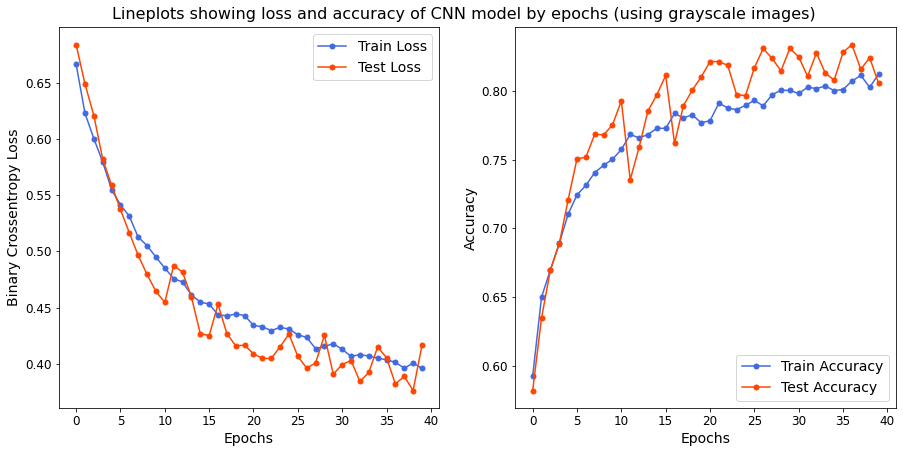

In [18]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss1, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss1, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Binary Crossentropy Loss', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy1, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy1, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs (using grayscale images)", fontsize=16)


#### Testing on Test set of images

In [19]:
labels =["Male",       # index 0
        "Female",      # index 1
        ]

print('Male ->', '0', '\nFemale ->', '1')

Male -> 0 
Female -> 1


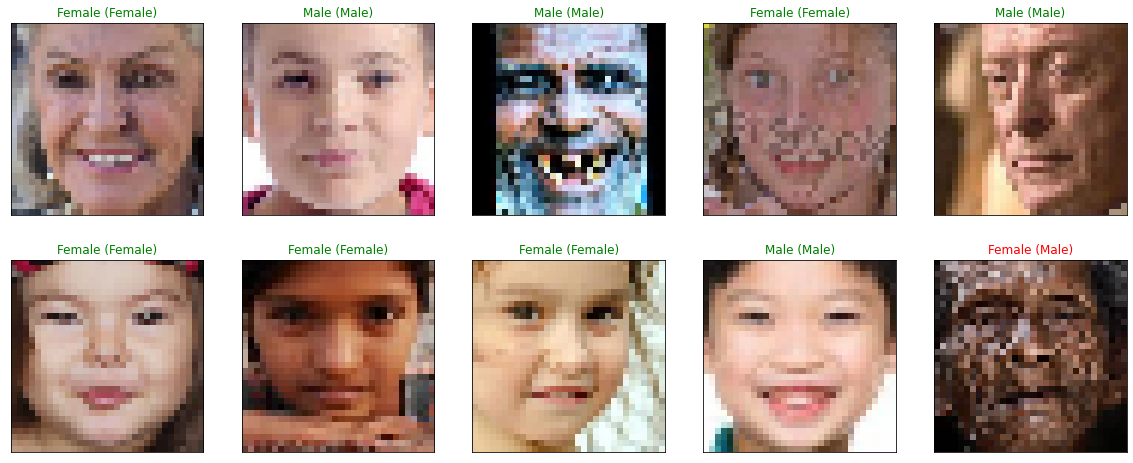

In [47]:
y_hat = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
    
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
    
    
plt.show()

## Testing on external images

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

In [22]:
# load and evaluate a saved model
import tensorflow as tf 
from numpy import loadtxt

 
# load model
model = tf.keras.models.load_model('gender.h5')
# summarize model.
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 64)        832       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)             

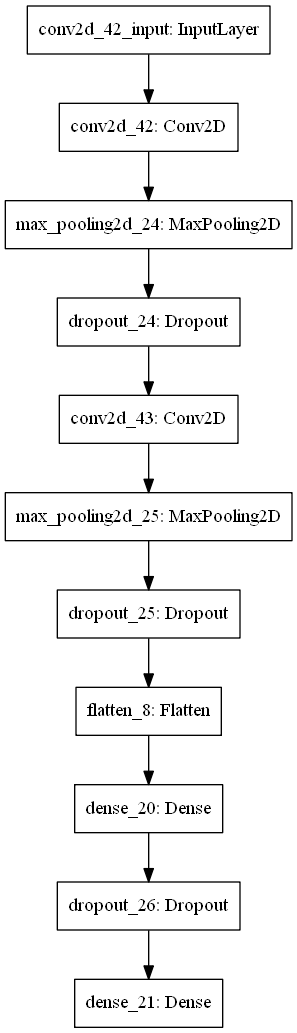

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='g_model.png')

Predicted Sex: Female


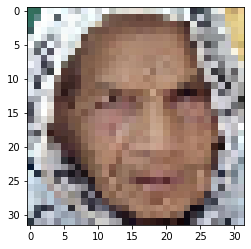

In [35]:

im1="C:/Users/shch/Desktop/Face_data_based_deeplearning-master/sample/oldw1.jpeg"

image=cv2.imread(im1)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image,(32,32))
image_f=np.array(image)
plt.imshow(image_f)
image_f_2=image_f/255
pred_1=model.predict(np.array([image_f_2]))
# pred_1
sex_f=['Male','Female']
sex=np.argmax(pred_1)
print("Predicted Sex: "+ sex_f[sex])

Predicted Sex: Female


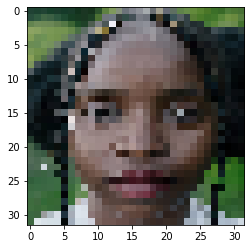

In [34]:

im1="C:/Users/shch/Desktop/Face_data_based_deeplearning-master/sample/girl1.jpg"
image=cv2.imread(im1)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image,(32,32))
image_f=np.array(image)
plt.imshow(image_f)
image_f_2=image_f/255
pred_1=model.predict(np.array([image_f_2]))
# pred_1
sex_f=['Male','Female']
sex=np.argmax(pred_1)
print("Predicted Sex: "+ sex_f[sex])

Predicted Sex: Female


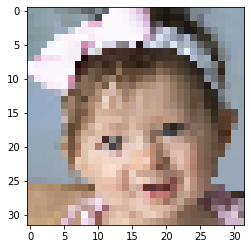

In [42]:

im1="C:/Users/shch/Desktop/Face_data_based_deeplearning-master/sample/baby2.jpg"

image=cv2.imread(im1)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image,(32,32))
image_f=np.array(image)
plt.imshow(image_f)
image_f_2=image_f/255
pred_1=model.predict(np.array([image_f_2]))
# pred_1
sex_f=['Male','Female']
sex=np.argmax(pred_1)
print("Predicted Sex: "+ sex_f[sex])

Predicted Sex: Male


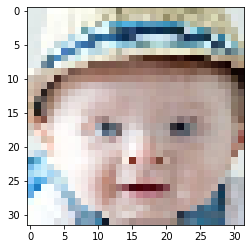

In [44]:

im1="C:/Users/shch/Desktop/Face_data_based_deeplearning-master/sample/baby3.jpg"

image=cv2.imread(im1)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image,(32,32))
image_f=np.array(image)
plt.imshow(image_f)
image_f_2=image_f/255
pred_1=model.predict(np.array([image_f_2]))
# pred_1
sex_f=['Male','Female']
sex=np.argmax(pred_1)
print("Predicted Sex: "+ sex_f[sex])